In [77]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import numba
from numba import njit,jit
import gsw

In [2]:
dens = xr.open_dataset('woa18_A5B7_I00_04.nc',decode_times=False).I_an [0,:,:,:]
temp = xr.open_dataset('woa18_A5B7_t00_04.nc',decode_times=False).t_an [0,:,:,:]
salt = xr.open_dataset('woa18_A5B7_s00_04.nc',decode_times=False).s_an [0,:,:,:]

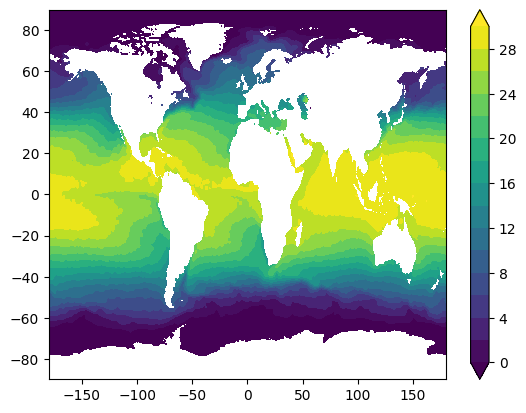

In [3]:
plt.contourf(dens['lon'],dens['lat'],temp[0,:,:],levels=20,extend='both')
plt.colorbar()

Text(0.5, 1.0, 'Salinity 28S60E IOSG')

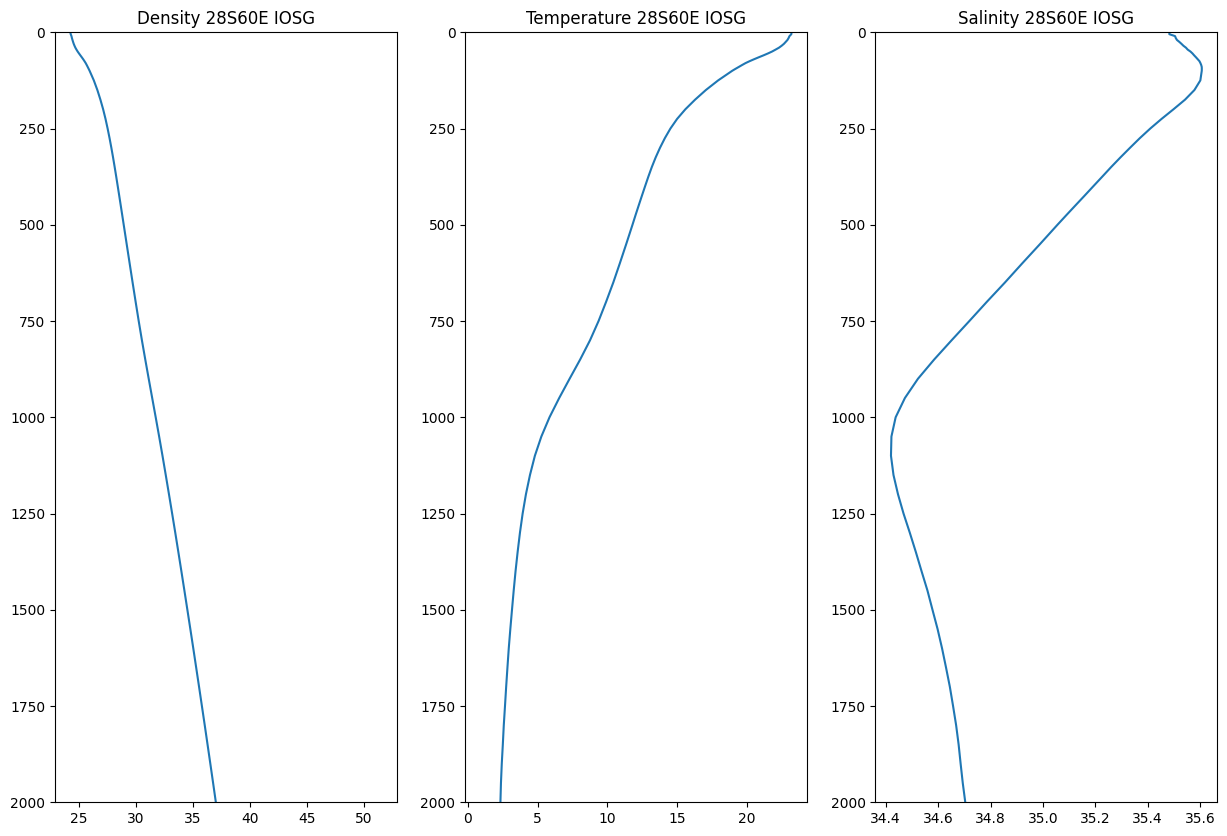

In [214]:
dens_iosg = dens.sel(lat=-28,lon=60,method='nearest')
temp_iosg = temp.sel(lat=-28,lon=60,method='nearest')
salt_iosg = salt.sel(lat=-28,lon=60,method='nearest')

fig, axs = plt.subplots(nrows=1,ncols=3,
                        figsize=(15,10))
axs[0].plot(dens_iosg,dens_iosg['depth'])
axs[0].set_ylim(2000,0)
axs[0].set_title('Density 28S60E IOSG')

axs[1].plot(temp_iosg,temp_iosg['depth'])
axs[1].set_ylim(2000,0)
axs[1].set_title('Temperature 28S60E IOSG')

axs[2].plot(salt_iosg,salt_iosg['depth'])
axs[2].set_ylim(2000,0)
axs[2].set_title('Salinity 28S60E IOSG')


Text(0.5, 1.0, 'Salinity curvature')

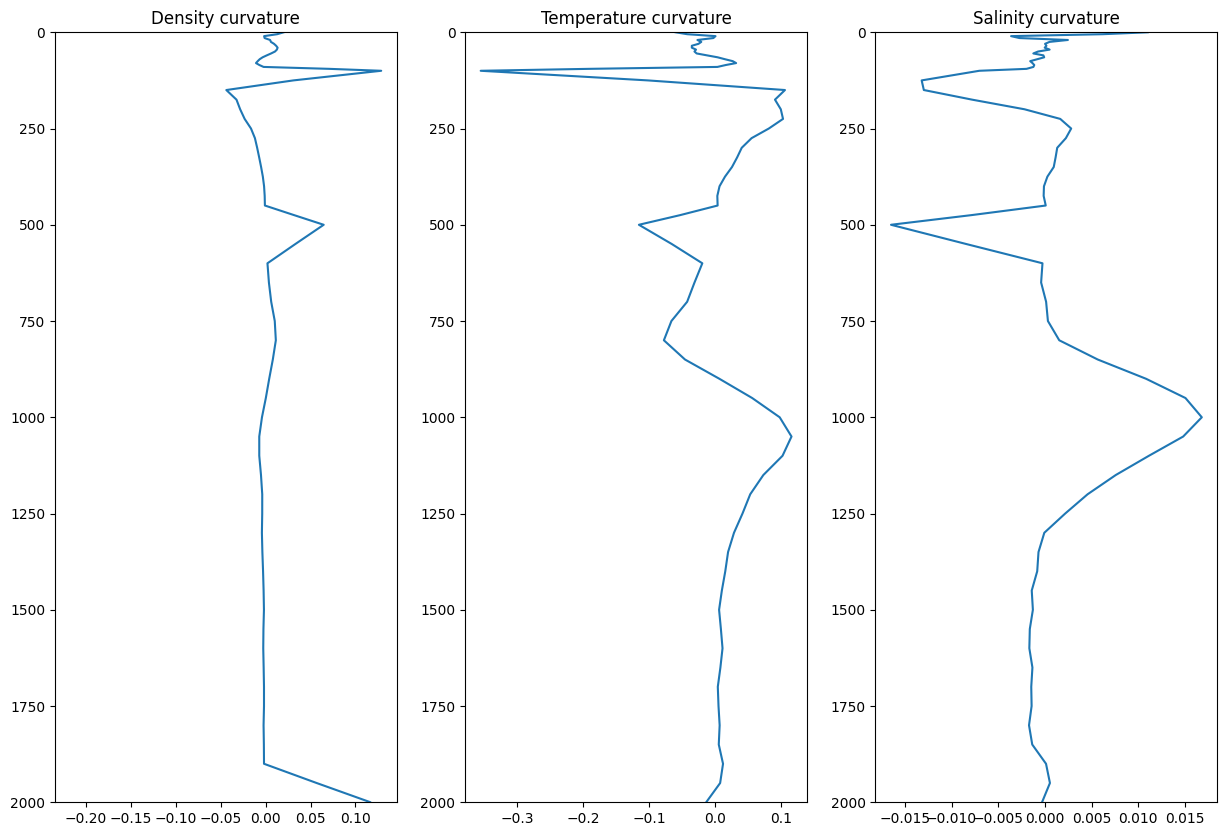

In [216]:
dens_iosg = dens.sel(lat=-28,lon=60,method='nearest')
temp_iosg = temp.sel(lat=-28,lon=60,method='nearest')
salt_iosg = salt.sel(lat=-28,lon=60,method='nearest')

fig, axs = plt.subplots(nrows=1,ncols=3,
                        figsize=(15,10))
axs[0].plot(np.gradient(np.gradient(dens_iosg,axis=0),axis=0),dens_iosg['depth'])
axs[0].set_ylim(2000,0)
axs[0].set_title('Density curvature')

axs[1].plot(np.gradient(np.gradient(temp_iosg,axis=0),axis=0),temp_iosg['depth'])
axs[1].set_ylim(2000,0)
axs[1].set_title('Temperature curvature')

axs[2].plot(np.gradient(np.gradient(salt_iosg,axis=0),axis=0),salt_iosg['depth'])
axs[2].set_ylim(2000,0)
axs[2].set_title('Salinity curvature')


In [23]:
import numpy as np

def compute_thermocline_depth(z, T):
    
    """
    Compute thermocline depth using the maximum temperature gradient method.
    """
    
    sorted_indices = np.argsort(z)
    z, T = z[sorted_indices], T[sorted_indices]
    
    # dTdz = np.gradient(T, z)
    dz = np.diff(z)
    dT = np.diff(T)
    dTdz = dT / dz  # Compute gradient manually
    
    # Restrict search between 10m and 1000m to avoid surface noise
    mask = (z[1:] >= 10) & (z[1:] <= 1000)
    z_masked, dTdz_masked = z[1:][mask], dTdz[mask]
    
    # Find depth of maximum temperature gradient
    thermocline_depth = z_masked[np.argmax(np.abs(dTdz_masked))] if len(z_masked) > 0 else np.nan
    
    return thermocline_depth

if __name__ == "__main__":
    z = temp_iosg['depth'].values  # Depth profile
    T = temp_iosg.values  # Temperature profile
    
    thermocline_depth = compute_thermocline_depth(z, T)
    
    print(f"Thermocline depth (gradient method): {thermocline_depth:.2f} m")


Thermocline depth (gradient method): 65.00 m


In [217]:
import numpy as np
from numba import njit

# Ensure contiguous arrays
t_cline_depth = np.empty((720, 1440), dtype=np.float64) 
z = np.ascontiguousarray(temp['depth'].values)  # Depth array
T = np.ascontiguousarray(temp.values)  # Temperature array

@njit
def calc_Tcline_depth(z, T):
    t_cline_depth = np.empty((720, 1440), dtype=np.float64) 

    for i in range(720):
        for j in range(1440):
            T_profile = T[:, i, j].copy() 

            dz = np.diff(z) 
            dT = np.diff(T_profile)  
            dTdz = dT / dz  # Compute temperature gradient manually

            mask = (z[1:] >= 10) & (z[1:] <= 1000)  # Mask valid depth range
            z_masked, dTdz_masked = z[1:][mask], dTdz[mask]

            if len(z_masked) > 0:
                t_cline_depth[i, j] = z_masked[np.argmax(np.abs(dTdz_masked))]
            else:
                t_cline_depth[i, j] = np.nan  # Ensure NaN for missing values

    return t_cline_depth

t_cline_depth = calc_Tcline_depth(z, T)

In [218]:
thermo_cline_depth = temp[0,:,:]*0 + t_cline_depth

Text(0.5, 1.0, '2005-2017 climatologically averaged Thermocline depth (m)')

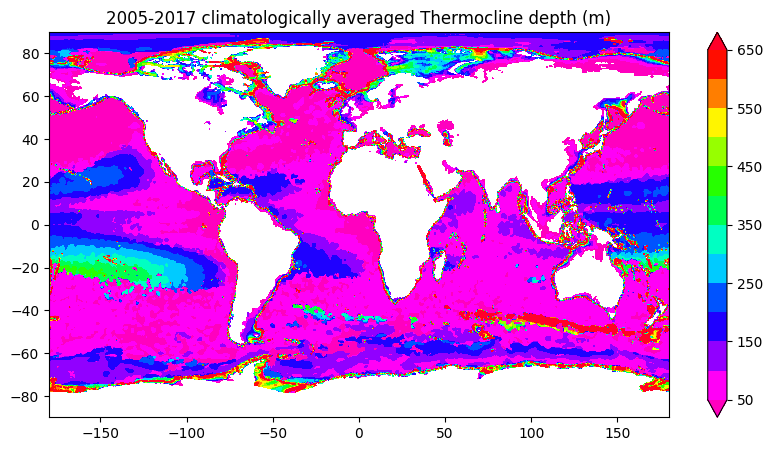

In [219]:
plt.figure(figsize=(10,5))
plt.contourf(temp['lon'],temp['lat'],thermo_cline_depth,np.arange(50,700,50),cmap='gist_rainbow_r',extend='both')
plt.colorbar()
plt.title('2005-2017 climatologically averaged Thermocline depth (m)')

In [220]:
import numpy as np
from numba import njit

# Ensure contiguous arrays
p_cline_depth = np.empty((720, 1440), dtype=np.float64) 
z = np.ascontiguousarray(dens['depth'].values)  # Depth array
D = np.ascontiguousarray(dens.values)  # Density array

@njit
def calc_Pcline_depth(z, D):
    p_cline_depth = np.empty((720, 1440), dtype=np.float64) 

    for i in range(720):
        for j in range(1440):
            D_profile = D[:, i, j].copy()

            dz = np.diff(z) 
            dD = np.diff(D_profile) 
            dDdz = dD / dz  # Compute density gradient manually

            mask = (z[1:] >= 10) & (z[1:] <= 1000)  # Mask valid depth range
            z_masked, dDdz_masked = z[1:][mask], dDdz[mask]

            if len(z_masked) > 0:
                p_cline_depth[i, j] = z_masked[np.argmax(np.abs(dDdz_masked))]
            else:
                p_cline_depth[i, j] = np.nan  

    return p_cline_depth

p_cline_depth = calc_Pcline_depth(z, D)

In [221]:
pycno_cline_depth = dens[0,:,:]*0 + p_cline_depth

Text(0.5, 1.0, '2005-2017 climatologically averaged Pycnocline depth (m)')

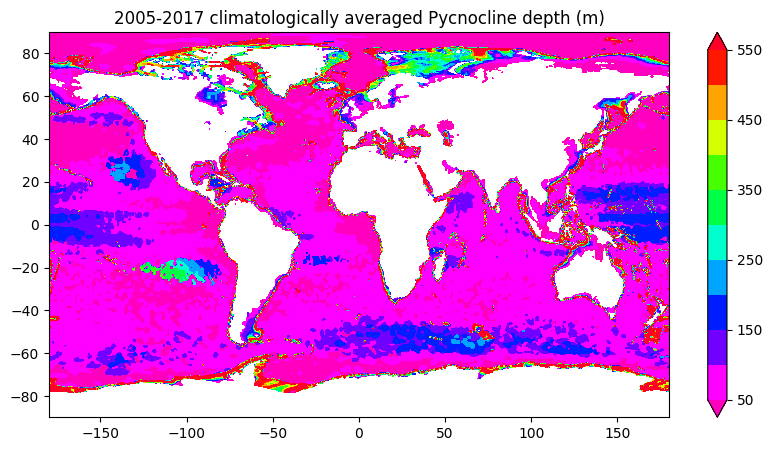

In [222]:
plt.figure(figsize=(10,5))
plt.contourf(dens['lon'],dens['lat'],pycno_cline_depth,np.arange(50,600,50),cmap='gist_rainbow_r',extend='both')
plt.colorbar()
plt.title('2005-2017 climatologically averaged Pycnocline depth (m)')

### Stability Parameters (from gsw toolkit)

In [179]:
pressure = temp*0
for i in range(0,1440):
    pressure[:,:,i] = gsw.conversions.p_from_z(-temp[:,:,i].depth, temp[:,:,i].lat, geo_strf_dyn_height=0, sea_surface_geopotential=0)

cons_temp = gsw.conversions.CT_from_t(salt, temp, pressure)

sig0 = gsw.density.sigma0(salt, cons_temp)

N_sqr_np,p_mid_np = gsw.stability.Nsquared(salt, cons_temp, pressure, lat=None, axis=0)
N_sqr = xr.DataArray(N_sqr_np, 
coords={'press': p_mid_np[:,0,0],'lat': temp.lat,'lon': temp.lon}, 
dims=["press", "lat", "lon"])

Tu_np, Rsub_rho_np, p_mid_np = gsw.stability.Turner_Rsubrho(salt, cons_temp, pressure, axis=0)
Tu = xr.DataArray(Tu_np, 
coords={'press': p_mid_np[:,0,0],'lat': temp.lat,'lon': temp.lon}, 
dims=["press", "lat", "lon"])
Rsub_rho = xr.DataArray(Rsub_rho_np, 
coords={'press': p_mid_np[:,0,0],'lat': temp.lat,'lon': temp.lon}, 
dims=["press", "lat", "lon"])

alpha = gsw.density.alpha(salt, cons_temp, pressure)
beta = gsw.density.beta(salt, cons_temp, pressure)

spec_vol_anom_np = gsw.density.specvol_anom_standard(salt, cons_temp, pressure)
spec_vol_anom = xr.DataArray(spec_vol_anom_np, 
coords={'depth': temp.depth,'lat': temp.lat,'lon': temp.lon}, 
dims=["depth", "lat", "lon"])

In [210]:
N_t_sqr = -(9.81/1025)*alpha*np.gradient(cons_temp, temp.depth, axis=0)
N_s_sqr = (9.81/1025)*beta*np.gradient(salt, salt.depth, axis=0)
# N_sqr_self_np = (9.81/1025)*np.gradient(sig0, sig0.depth, axis=0)
# N_sqr_self = xr.DataArray(N_sqr_self_np, 
# coords={'depth': temp.depth,'lat': temp.lat,'lon': temp.lon}, 
# dims=["depth", "lat", "lon"])

## Section along 26W (Atlantic N-S)

Text(0.75, 0.1, 'v (m³/kg)')

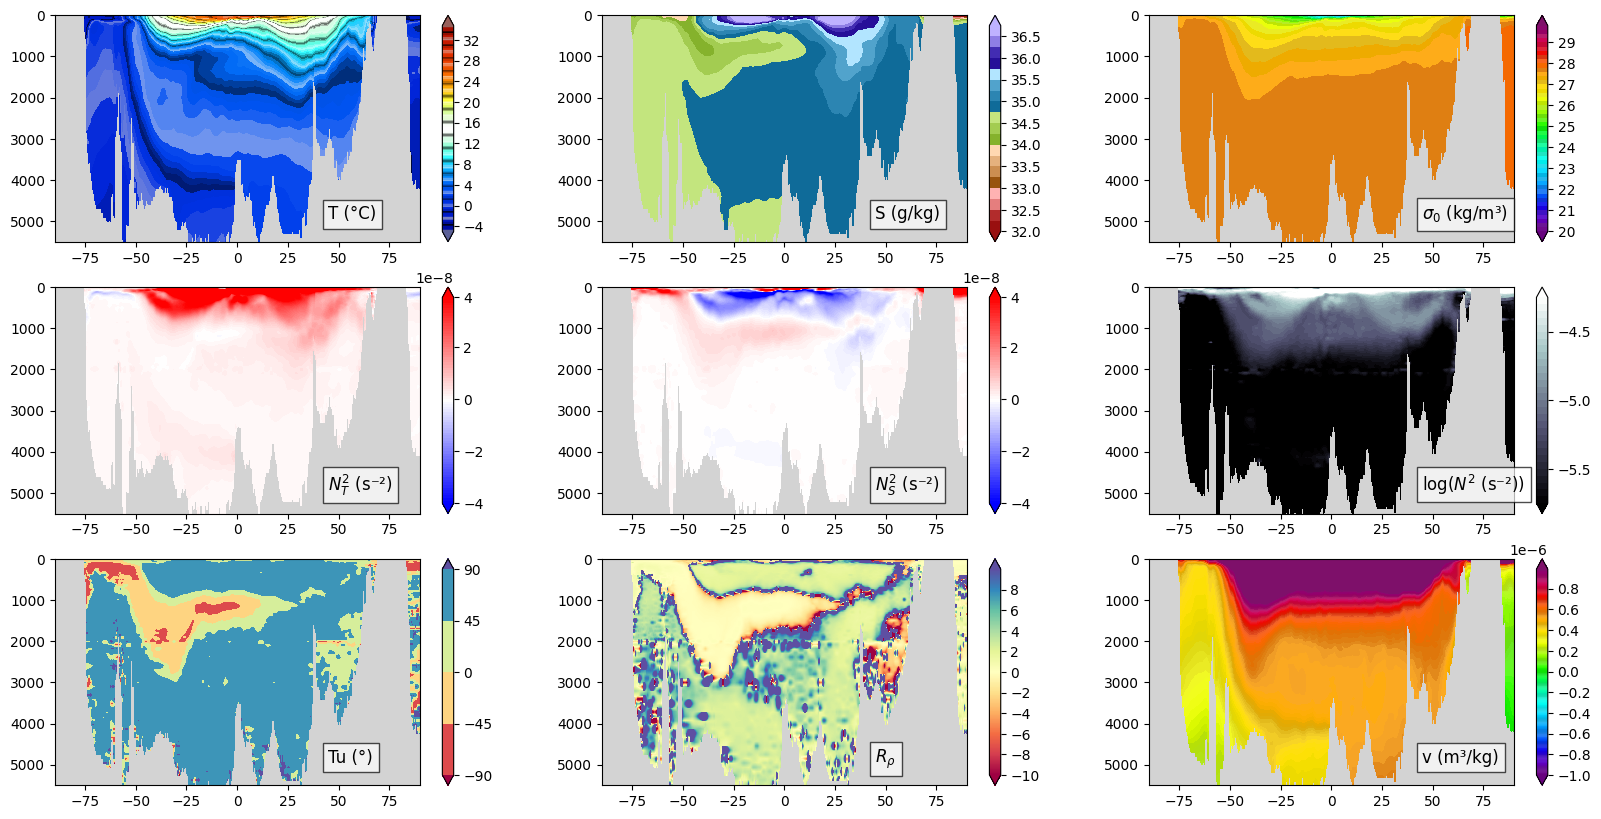

In [241]:
fig = plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

ax0 = plt.subplot(3, 3, 1)
c0 = ax0.contourf(temp['lat'],temp['depth'],cons_temp.sel(lon=-26,method='nearest'),np.arange(-5,35,0.25),cmap=nclcmaps.cmaps('NCV_roullet'),extend='both')
ax0.set_facecolor("lightgrey")
ax0.set_ylim(5500,0)
plt.colorbar(c0)
ax0.text(
        0.75, 0.1, 'T (°C)', transform=ax0.transAxes, fontsize=12,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
    )

ax1 = plt.subplot(3, 3, 2)
c1 = ax1.contourf(temp['lat'],temp['depth'],salt.sel(lon=-26,method='nearest'),np.arange(32,37,0.25),cmap=nclcmaps.cmaps('StepSeq25'),extend='both')
ax1.set_facecolor("lightgrey")
ax1.set_ylim(5500,0)
plt.colorbar(c1)
ax1.text(
        0.75, 0.1, 'S (g/kg)', transform=ax1.transAxes, fontsize=12,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
    )

ax2 = plt.subplot(3, 3, 3)
c2 = ax2.contourf(temp['lat'],temp['depth'],sig0.sel(lon=-26,method='nearest'),np.arange(20,30,0.2),cmap=nclcmaps.cmaps('NCV_banded'),extend='both')
ax2.set_facecolor("lightgrey")
ax2.set_ylim(5500,0)
plt.colorbar(c2)
ax2.text(
        0.75, 0.1, r'$\sigma_0$ (kg/m³)', transform=ax2.transAxes, fontsize=12,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
    )

ax3 = plt.subplot(3, 3, 4)
c3 = ax3.contourf(temp['lat'],temp['depth'],N_t_sqr.sel(lon=-26,method='nearest'),np.arange(-4e-8,4e-8,1e-9),cmap='bwr',extend='both')
ax3.set_facecolor("lightgrey")
ax3.set_ylim(5500,0)
plt.colorbar(c3,ticks=[-4e-8,-2e-8,0,2e-8,4e-8])
ax3.text(
        0.75, 0.1, r"$N_T^2$ (s⁻²)", transform=ax3.transAxes, fontsize=12,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
    )

ax4 = plt.subplot(3, 3, 5)
c4 = ax4.contourf(temp['lat'],temp['depth'],N_s_sqr.sel(lon=-26,method='nearest'),np.arange(-4e-8,4e-8,1e-9),cmap='bwr',extend='both')
ax4.set_facecolor("lightgrey")
ax4.set_ylim(5500,0)
plt.colorbar(c4,ticks=[-4e-8,-2e-8,0,2e-8,4e-8])
ax4.text(
        0.75, 0.1, r"$N_S^2$ (s⁻²)", transform=ax4.transAxes, fontsize=12,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
    )

ax5 = plt.subplot(3, 3, 6)
c5 = ax5.contourf(N_sqr['lat'],N_sqr['press'],np.log10(np.abs(N_sqr.sel(lon=-26, method='nearest'))),np.arange(-5.75, -4.24, 0.05),cmap='bone',extend='both')
ax5.set_facecolor("lightgrey")
ax5.set_ylim(5500,0)
plt.colorbar(c5,ticks=[-5.5,-5,-4.5])
ax5.text(
        0.75, 0.1, r"log($N^2$ (s⁻²))", transform=ax5.transAxes, fontsize=12,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
    )

ax6 = plt.subplot(3, 3, 7)
c6 = ax6.contourf(temp['lat'],Tu['press'],Tu.sel(lon=-26,method='nearest'),np.arange(-90,130,45),cmap='Spectral',extend='both')
ax6.set_facecolor("lightgrey")
ax6.set_ylim(5500,0)
plt.colorbar(c6)
ax6.text(
        0.75, 0.1, "Tu (°)", transform=ax6.transAxes, fontsize=12,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
    )

ax7 = plt.subplot(3, 3, 8)
c7 = ax7.contourf(temp['lat'],Rsub_rho['press'],Rsub_rho.sel(lon=-26,method='nearest'),np.arange(-10,10,0.01),cmap='Spectral',extend='both')
ax7.set_facecolor("lightgrey")
ax7.set_ylim(5500,0)
plt.colorbar(c7)
ax7.text(
        0.75, 0.1, r"$R_{\rho}$", transform=ax7.transAxes, fontsize=12,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
    )

ax8 = plt.subplot(3, 3, 9)
c8 = ax8.contourf(temp['lat'],temp['depth'],spec_vol_anom.sel(lon=-26,method='nearest'),np.arange(-1e-6,1e-6,1e-8),cmap=nclcmaps.cmaps('NCV_banded'),extend='both')
ax8.set_facecolor("lightgrey")
ax8.set_ylim(5500,0)
plt.colorbar(c8)
ax8.text(
        0.75, 0.1, "v (m³/kg)", transform=ax8.transAxes, fontsize=12,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
    )

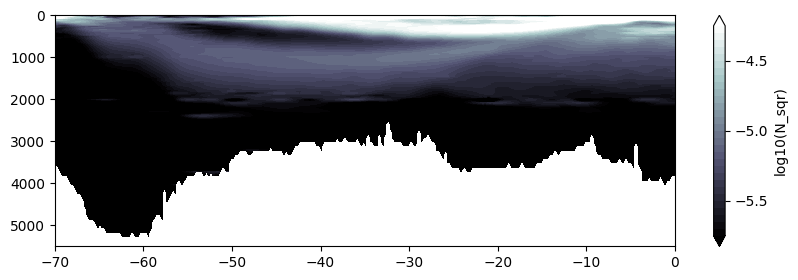

In [244]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
# N_sqr_log = np.sign(N_sqr.sel(lon=-26, method='nearest')) * np.log10(np.abs(N_sqr.sel(lon=-26, method='nearest') + 1e-10))

plt.contourf(N_sqr['lat'], N_sqr['press'], np.log10(np.abs(N_sqr.sel(lon=-110, method='nearest'))), 
             np.arange(-5.75, -4.24, 0.05), cmap='bone', extend='both')  
plt.colorbar(label='log10(N_sqr)',ticks=[-5.5,-5,-4.5])
plt.ylim(5500, 0) 
plt.xlim(-70,0)

plt.show()
